<ins>Logical Workflow PA Project</ins>

0. Call Data from SQL Server and save to local .pkl. Filter by TBM 1 and time span ('2022/02/01', '2022/04/01')
1. Join data for a complete dataset
2. Initial Filter (by Equipment ID: TBM 1 and remove Trial Recipes), key generation, cycle time generation and EDA
3. Left Merge Alarm mapping and Alarm hisroy on Created Key.
4. Alarm Discovery: Alarm to GT allocation: Calculate PAAP start and finish times if needed. Do NOT Filter alarms by Type e.g.  FF, CF and MC, assin name in#dexes. Link these alarm name indexes that are occurring for the same green tire at those times identified as PA. Create GT to Alarm Index Mapping.

3.  One Hot encode Alarm Indexes before we carry out feature selction to see relevant alarms.
4.  Feature selection: Initial Filter using statistical univariate filter methods. 
5.  Feature selection: Narrow down using ML Models. Identify which steps are posing the issue (i.e. is it sidewall, inner liner, is it transport time etc.)
6.	Link a machine parameter to this step, and create a model to correct it. 


In [2]:
import pandas as pd
import pandas as pd
import numpy as np
import seaborn as sns
from helpers import TBM, bcolors, Data_Functions
import matplotlib.pyplot as plt

DF = Data_Functions()
TBM = TBM()
p = bcolors()

In [2]:
df_map = pd.read_pickle("./pkl/df_map_filtered_key.pkl")
df_alarm = pd.read_pickle("./pkl/df_alarm_filtered_key.pkl")
df_tbm = pd.read_pickle("./pkl/df_tbm_filtered_cycle_times.pkl")

In [9]:
df_map.Name.unique

<bound method Series.unique of 9721             MOTION COMMUNICATION FAILURE CARCASS SIDE
9730     MOTION COMMUNICATION FAILURE CW FABRIC / STEEL...
9739        ETHERNET CARD FOR DATA NETWORK FAILURE CC SIDE
9748         ETHERNET CARD FOR RIO NETWORK FAILURE CC SIDE
9757         FAILURE RIO 50, CARCASS SERVICER MAIN CABINET
                               ...                        
86508          PA MATERIAL STAYED ON CONVEYOR FOR TOO LONG
86520                PA MATERIAL REJECTED DUE TO SHRINKAGE
86524                                                  ???
86532          CARCASS DRUM, RECALIBRATE TRAVERSE POSITION
86537                                                  ???
Name: Name, Length: 8537, dtype: object>

In [6]:
df_map.head()

,MessageID,PlcNr,Type,Name,Solution,EquipmentID,key
9721,89031,1,FF,MOTION COMMUNICATION FAILURE CARCASS SIDE,CHECK MOTION NETWORK,TBM 1,89031TBM_1
9730,89032,2,FF,MOTION COMMUNICATION FAILURE CW FABRIC / STEEL...,CHECK MOTION NETWORK,TBM 1,89032TBM_1
9739,89033,3,FF,ETHERNET CARD FOR DATA NETWORK FAILURE CC SIDE,CHECK ETHERNET CARD ON PLC BACKPLANE,TBM 1,89033TBM_1
9748,89034,4,FF,ETHERNET CARD FOR RIO NETWORK FAILURE CC SIDE,CHECK ETHERNET CARD ON PLC BACKPLANE,TBM 1,89034TBM_1
9757,89035,5,FF,"FAILURE RIO 50, CARCASS SERVICER MAIN CABINET",CHECK RIO STATION,TBM 1,89035TBM_1


In [3]:
# View Available Cycle Times
column_list = df_tbm.columns
str_match = [s for s in column_list if "CYCLE_TIME" in s]
print(str_match)
p.printc(f'Step Cycle Times Available: {p.ENDC}{len(str_match)}')

['VRL_VHMC_MES_BTPR_CYCLE_TIME_1BAP', 'VRL_VHMC_MES_BTPR_CYCLE_TIME_2BAP', 'VRL_VHMC_MES_BTPR_CYCLE_TIME_CWAP', 'VRL_VHMC_MES_BTPR_CYCLE_TIME_TDAP', 'VRL_VHMC_MES_BTPR_CYCLE_TIME_WAIT_CC', 'VRL_VHMC_MES_BTPR_CYCLE_TIME_BTRE', 'VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP', 'VRL_VHMC_MES_CCPR_CYCLE_TIME_STITCH_BP', 'VRL_VHMC_MES_CCPR_CYCLE_TIME_WAIT_BEADS', 'VRL_VHMC_MES_CCPR_CYCLE_TIME_WAIT_BT', 'VRL_VHMC_MES_CCPR_CYCLE_TIME_STITCH_PA', 'VRL_VHMC_MES_CCPR_CYCLE_TIME_1PAP', 'VRL_VHMC_MES_CCPR_CYCLE_TIME_2PAP', 'VRL_VHMC_MES_CCPR_CYCLE_TIME_SCAP', 'VRL_VHMC_MES_CCPR_CYCLE_TIME_FCAP', 'VRL_VHMC_MES_CCPR_CYCLE_TIME_STITCH_FC', 'VRL_VHMC_MES_CCPR_CYCLE_TIME_RSAP', 'VRL_VHMC_MES_CCPR_CYCLE_TIME_STITCH_RS', 'VRL_VHMC_MES_CCPR_CYCLE_TIME_BDSG', 'VRL_VHMC_MES_CCPR_CYCLE_TIME_RLCY', 'VRL_VHMC_MES_CCPR_CYCLE_TIME_SHAPE', 'VRL_VHMC_MES_CCPR_CYCLE_TIME_TDST', 'VRL_VHMC_MES_CCPR_CYCLE_TIME_SWST', 'VRL_VHMC_MES_CCPR_CYCLE_TIME_GTRU']
Step Cycle Times Available: 24


In [4]:
# View the mean time of each of these Steps
df_tbm[str_match].mean()

VRL_VHMC_MES_BTPR_CYCLE_TIME_1BAP           7.162025
VRL_VHMC_MES_BTPR_CYCLE_TIME_2BAP           7.890821
VRL_VHMC_MES_BTPR_CYCLE_TIME_CWAP          16.229608
VRL_VHMC_MES_BTPR_CYCLE_TIME_TDAP          11.835342
VRL_VHMC_MES_BTPR_CYCLE_TIME_WAIT_CC       19.963537
VRL_VHMC_MES_BTPR_CYCLE_TIME_BTRE           3.228175
VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP           5.660759
VRL_VHMC_MES_CCPR_CYCLE_TIME_STITCH_BP      0.964752
VRL_VHMC_MES_CCPR_CYCLE_TIME_WAIT_BEADS     0.000000
VRL_VHMC_MES_CCPR_CYCLE_TIME_WAIT_BT        0.005760
VRL_VHMC_MES_CCPR_CYCLE_TIME_STITCH_PA     14.470940
VRL_VHMC_MES_CCPR_CYCLE_TIME_1PAP          12.539087
VRL_VHMC_MES_CCPR_CYCLE_TIME_2PAP           2.063069
VRL_VHMC_MES_CCPR_CYCLE_TIME_SCAP           0.000000
VRL_VHMC_MES_CCPR_CYCLE_TIME_FCAP                NaN
VRL_VHMC_MES_CCPR_CYCLE_TIME_STITCH_FC           NaN
VRL_VHMC_MES_CCPR_CYCLE_TIME_RSAP           0.000000
VRL_VHMC_MES_CCPR_CYCLE_TIME_STITCH_RS      0.000000
VRL_VHMC_MES_CCPR_CYCLE_TIME_BDSG           1.

Diagram displaying how to link these Steps logically to machine operation

![SNOWFALL](img/cycleAnnotated.png)

PAAP is the target. We consider that 'producedOn' time accounts for GT removal time. For this reason, we add all the subsequent steps together. 

In [10]:
# Comparison of confusing Cycle Times and Step Times. For context: 'VRL_VHMC_MES_PAPR_CYCLE_TOTAL' : 'Preasembly_Cycle_Time_Total'
df_tbm['naive_addition_of_step_times'] = df_tbm[str_match].sum(axis=1)
comparison = df_tbm[['VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP', 'Preasembly_Cycle_Time_Total', 'cycle_time_s', 'naive_addition_of_step_times']]
comparison.rename(columns={'Preasembly_Cycle_Time_Total': 'VRL_VHMC_MES_PAPR_CYCLE_TOTAL'}, inplace=True)
comparison['naive_addition_of_step_times'] = df_tbm[str_match].sum(axis=1)
# View a random sample of 10 from this comparison table
comparison.sample(10)

,VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP,VRL_VHMC_MES_PAPR_CYCLE_TOTAL,cycle_time_s,naive_addition_of_step_times
89892,3.934,39.236000,39,73.241001
19923,3.930,41.983002,39,76.923000
52831,7.606,35.228001,475,187.573000
69165,3.908,39.012001,65,178.763003
57537,3.932,38.396999,41,76.265000
61140,3.926,38.941002,39,73.459001
58399,3.999,42.465000,43,80.417999
23687,3.899,37.457001,103,70.860999
96899,3.921,43.527000,45,79.741999
87974,4.050,39.980000,68,131.720999


TIME_PAAP: Application time on drum
VRL_VHMC_MES_PAPR_CYCLE_TOTAL: Total time from preparation of Sidewall and Inner liner material. This include cutting, preparation, transfer

Calculate PAAP start and end times

In [11]:
df_tbm['sum_subsequent_steps'] = df_tbm[['VRL_VHMC_MES_CCPR_CYCLE_TIME_STITCH_BP', 'VRL_VHMC_MES_CCPR_CYCLE_TIME_WAIT_BEADS', 'VRL_VHMC_MES_CCPR_CYCLE_TIME_WAIT_BT', 'VRL_VHMC_MES_CCPR_CYCLE_TIME_STITCH_PA', 'VRL_VHMC_MES_CCPR_CYCLE_TIME_1PAP', 'VRL_VHMC_MES_CCPR_CYCLE_TIME_2PAP', 'VRL_VHMC_MES_CCPR_CYCLE_TIME_BDSG', 'VRL_VHMC_MES_CCPR_CYCLE_TIME_RLCY', 'VRL_VHMC_MES_CCPR_CYCLE_TIME_SHAPE', 'VRL_VHMC_MES_CCPR_CYCLE_TIME_TDST', 'VRL_VHMC_MES_CCPR_CYCLE_TIME_SWST','VRL_VHMC_MES_CCPR_CYCLE_TIME_GTRU']].sum(axis=1)

In [12]:
df_tbm['PAAP_Finish_time'] = df_tbm['ProducedOn'] - pd.to_timedelta(df_tbm['sum_subsequent_steps'], unit='s')
df_tbm['PAAP_Start_time'] = df_tbm['PAAP_Finish_time'] - pd.to_timedelta(df_tbm['VRL_VHMC_MES_CCPR_CYCLE_TIME_PAAP'], unit='s')
df_tbm.head(4)

,ProducedOn,EquipmentID,ProductionDataId,UserGroupName,Name_of_Active_Operator,RecipeName,Name_of_Active_Production_Order,date/time,Barcode_on_build_tire,GT_Code_of_the_built_tire,...,VRL_VHMC_MES_CCPR_CYCLE_TIME_TDST,VRL_VHMC_MES_CCPR_CYCLE_TIME_SWST,VRL_VHMC_MES_CCPR_CYCLE_TIME_GTRU,Id,start_time,cycle_time_s,naive_addition_of_step_times,sum_subsequent_steps,PAAP_Finish_time,PAAP_Start_time
0,2022-02-01 06:03:43,TBM 1,1347468,Operator,Operator 065,GG224517HYPXY,T2206001N000,20220201 06:03:43,0015600676,GG224517HYPXY,...,5.498,0.0,2.480,11141585,2022-02-01 06:02:06,97,219.620006,85.318002,2022-02-01 06:02:17.681997776,2022-02-01 06:02:12.754997730
1,2022-02-01 06:04:28,TBM 1,1347469,Operator,Operator 065,GG224517HYPXY,T2206001N000,20220201 06:04:28,0015600677,GG224517HYPXY,...,5.667,0.0,2.480,11141586,2022-02-01 06:03:43,45,137.105000,36.230000,2022-02-01 06:03:51.770000100,2022-02-01 06:03:47.783000111
2,2022-02-01 06:05:33,TBM 1,1347470,Operator,Operator 065,GG224517HYPXY,T2206001N000,20220201 06:05:33,0015600678,GG224517HYPXY,...,5.654,0.0,2.397,11141588,2022-02-01 06:04:28,65,92.177000,43.610000,2022-02-01 06:04:49.389999986,2022-02-01 06:04:45.452999950
3,2022-02-01 06:06:24,TBM 1,1347471,Operator,Operator 065,GG224517HYPXY,T2206001N000,20220201 06:06:24,0015600679,GG224517HYPXY,...,5.572,0.0,2.448,11141590,2022-02-01 06:05:33,51,102.747001,34.745000,2022-02-01 06:05:49.255000234,2022-02-01 06:05:45.262000203


In [13]:
df_map

,MessageID,PlcNr,Type,Name,Solution,EquipmentID,key
9721,89031,1,FF,MOTION COMMUNICATION FAILURE CARCASS SIDE,CHECK MOTION NETWORK,TBM 1,89031TBM_1
9730,89032,2,FF,MOTION COMMUNICATION FAILURE CW FABRIC / STEEL...,CHECK MOTION NETWORK,TBM 1,89032TBM_1
9739,89033,3,FF,ETHERNET CARD FOR DATA NETWORK FAILURE CC SIDE,CHECK ETHERNET CARD ON PLC BACKPLANE,TBM 1,89033TBM_1
9748,89034,4,FF,ETHERNET CARD FOR RIO NETWORK FAILURE CC SIDE,CHECK ETHERNET CARD ON PLC BACKPLANE,TBM 1,89034TBM_1
9757,89035,5,FF,"FAILURE RIO 50, CARCASS SERVICER MAIN CABINET",CHECK RIO STATION,TBM 1,89035TBM_1
...,...,...,...,...,...,...,...
86508,97563,50536002,OM,PA MATERIAL STAYED ON CONVEYOR FOR TOO LONG,CHECK PA SPLICE FOR 5 SECONDS AND PRESS STEP P...,TBM 1,97563TBM_1
86520,97564,50536003,OM,PA MATERIAL REJECTED DUE TO SHRINKAGE,REMOVE THE SCRAP MATERIAL FROM APPLICATOR,TBM 1,97564TBM_1
86524,97565,40475040,OM,???,None,TBM 1,97565TBM_1
86532,97566,60215126,MC,"CARCASS DRUM, RECALIBRATE TRAVERSE POSITION",RECALIBRATE TRAVERSE POSITION,TBM 1,97566TBM_1


Sometimes the alarm will stop the machine. Sometimes it wont 

FF	Fatal fault	Circuit breaker, motor, drive failure. Usually, manually interupt the safety. If there is some issue, when the machine gives a warning, then they will go and correct the problem and reset the alarm. 	Stop the m/c

CF	Cycle fault	Overloading due to sticky issue	Stop the m/c

MC	Missing Condition	Misisng of raw material	Mostly won't stop the m/c

OM	Operator message	FYI

OM causes a cascade of alarms which may be FF which are more generic. So do not filter here. 

In [14]:
filtered_df = df_map[df_map['Type'].isin(['FF', 'CF', 'MC', 'OM'])]

In [15]:
filtered_df

,MessageID,PlcNr,Type,Name,Solution,EquipmentID,key
9721,89031,1,FF,MOTION COMMUNICATION FAILURE CARCASS SIDE,CHECK MOTION NETWORK,TBM 1,89031TBM_1
9730,89032,2,FF,MOTION COMMUNICATION FAILURE CW FABRIC / STEEL...,CHECK MOTION NETWORK,TBM 1,89032TBM_1
9739,89033,3,FF,ETHERNET CARD FOR DATA NETWORK FAILURE CC SIDE,CHECK ETHERNET CARD ON PLC BACKPLANE,TBM 1,89033TBM_1
9748,89034,4,FF,ETHERNET CARD FOR RIO NETWORK FAILURE CC SIDE,CHECK ETHERNET CARD ON PLC BACKPLANE,TBM 1,89034TBM_1
9757,89035,5,FF,"FAILURE RIO 50, CARCASS SERVICER MAIN CABINET",CHECK RIO STATION,TBM 1,89035TBM_1
...,...,...,...,...,...,...,...
86508,97563,50536002,OM,PA MATERIAL STAYED ON CONVEYOR FOR TOO LONG,CHECK PA SPLICE FOR 5 SECONDS AND PRESS STEP P...,TBM 1,97563TBM_1
86520,97564,50536003,OM,PA MATERIAL REJECTED DUE TO SHRINKAGE,REMOVE THE SCRAP MATERIAL FROM APPLICATOR,TBM 1,97564TBM_1
86524,97565,40475040,OM,???,None,TBM 1,97565TBM_1
86532,97566,60215126,MC,"CARCASS DRUM, RECALIBRATE TRAVERSE POSITION",RECALIBRATE TRAVERSE POSITION,TBM 1,97566TBM_1


In [22]:
boolean_series = df_alarm.key.isin(filtered_df["key"])
assert boolean_series.sum() == len(boolean_series)
filtered_df_alarm = df_alarm[boolean_series]
len(filtered_df_alarm)

1347322

In [23]:
filtered_df_alarm

,HistoryMessageID,MessageID,TimeStamp,Duration,EquipmentID,key
648,20839674,96387,2022-02-02 12:01:44.4784040,83,TBM 1,96387TBM_1
649,20839675,96095,2022-02-02 12:01:49.2675426,35,TBM 1,96095TBM_1
680,20838979,95137,2022-02-02 11:14:26.1490363,4,TBM 1,95137TBM_1
681,20838980,95211,2022-02-02 11:14:36.1796434,11,TBM 1,95211TBM_1
682,20838981,95369,2022-02-02 11:14:36.1796434,91,TBM 1,95369TBM_1
...,...,...,...,...,...,...
7982307,21714967,96674,2022-03-16 23:12:49.1422093,4,TBM 1,96674TBM_1
7982308,21714970,96675,2022-03-16 23:12:51.4822093,2,TBM 1,96675TBM_1
7982309,21714971,95776,2022-03-16 23:12:53.2762093,2,TBM 1,95776TBM_1
7982310,21714975,95771,2022-03-16 23:13:21.5590093,28,TBM 1,95771TBM_1


Merge on Key

In [24]:
filter_alarms = pd.merge(filtered_df[['key', 'Name', 'Type', 'MessageID']],filtered_df_alarm,on='key')
filter_alarms

,key,Name,Type,MessageID_x,HistoryMessageID,MessageID_y,TimeStamp,Duration,EquipmentID
0,89031TBM_1,MOTION COMMUNICATION FAILURE CARCASS SIDE,FF,89031,21906293,89031,2022-03-25 03:06:38.3988765,4,TBM 1
1,89031TBM_1,MOTION COMMUNICATION FAILURE CARCASS SIDE,FF,89031,21337964,89031,2022-02-27 11:32:38.1855400,4,TBM 1
2,89031TBM_1,MOTION COMMUNICATION FAILURE CARCASS SIDE,FF,89031,21017480,89031,2022-02-11 09:42:28.6704247,7,TBM 1
3,89031TBM_1,MOTION COMMUNICATION FAILURE CARCASS SIDE,FF,89031,21018750,89031,2022-02-11 11:10:13.6504815,4,TBM 1
4,89031TBM_1,MOTION COMMUNICATION FAILURE CARCASS SIDE,FF,89031,21906293,89031,2022-03-25 03:06:38.3988765,4,TBM 1
...,...,...,...,...,...,...,...,...,...
1347317,97567TBM_1,???,OM,97567,22618603,97567,2022-05-04 04:03:30.7745552,14,TBM 1
1347318,97567TBM_1,???,OM,97567,22495750,97567,2022-04-25 21:30:33.4923961,23,TBM 1
1347319,97567TBM_1,???,OM,97567,22474746,97567,2022-04-24 19:40:02.4974760,28,TBM 1
1347320,97567TBM_1,???,OM,97567,22474770,97567,2022-04-24 19:41:43.7408270,58,TBM 1


In [25]:
filter_alarms['MessageID_x'].equals(filter_alarms['MessageID_y'])

True

In [26]:
filter_alarms.drop(['MessageID_y'], axis=1, inplace=True)

c:\Users\shav.vimelindiran\Anaconda3\envs\ml\lib\site-packages\seaborn\distributions.py:948: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  scout = self.ax.fill_between([], [], **plot_kws)
c:\Users\shav.vimelindiran\Anaconda3\envs\ml\lib\site-packages\seaborn\distributions.py:991: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  artist = ax.fill_between(


Text(0.5, 1.0, 'Probablity Distribution of all Alarms')

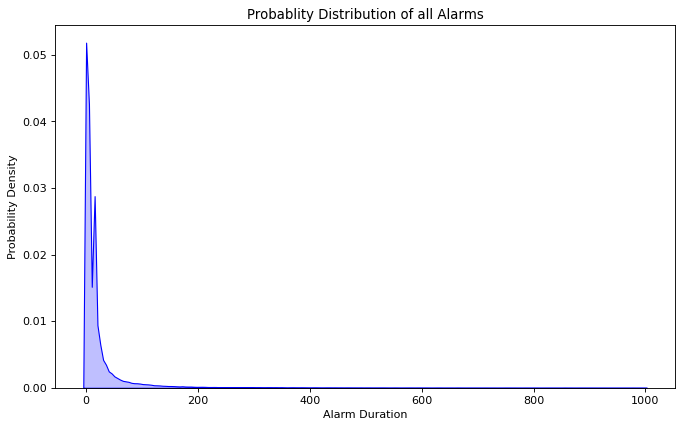

In [27]:
plt.figure(figsize=(10, 6), dpi=80)

# Rough initial view of Overall Cycle times. These are not sorted by RecipeName so this will be done later
# Plotting the KDE Plot
sns.kdeplot(filter_alarms.Duration[filter_alarms.Duration < 1000], color='b', shade=True, Label='Cycle_Time', bw_adjust=.4)
# sns.kdeplot(alarm_join.loc[(alarm_join['Name']=='PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE'),'Duration'][alarm_join.loc[(alarm_join['Name']=='PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE'),'Duration'] > 100], color='r', shade=True, Label='PRE_ASSEMBLY_LENGTH_OUT_OF_TOLERANCE')

# Setting the X and Y Label
plt.xlabel('Alarm Duration')
plt.ylabel('Probability Density')
plt.title('Probablity Distribution of all Alarms')

c:\Users\shav.vimelindiran\Anaconda3\envs\ml\lib\site-packages\seaborn\distributions.py:948: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  scout = self.ax.fill_between([], [], **plot_kws)
c:\Users\shav.vimelindiran\Anaconda3\envs\ml\lib\site-packages\seaborn\distributions.py:991: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  artist = ax.fill_between(


Text(0.5, 1.0, "Probablity Distribution of 'PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE' Alarm")

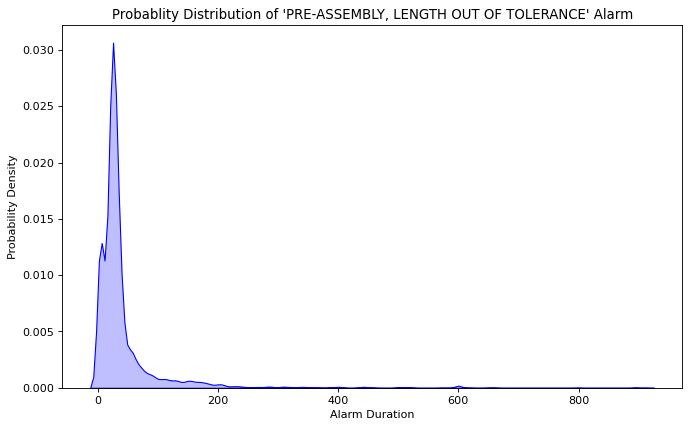

In [22]:
plt.figure(figsize=(10, 6), dpi=80)

# Rough initial view of Overall Cycle times. These are not sorted by RecipeName so this will be done later
# Plotting the KDE Plot
sns.kdeplot(filter_alarms.Duration[filter_alarms.Name == 'PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE'], color='b', shade=True, Label='Cycle_Time', bw_adjust=.4)
# sns.kdeplot(alarm_join.loc[(alarm_join['Name']=='PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE'),'Duration'][alarm_join.loc[(alarm_join['Name']=='PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE'),'Duration'] > 100], color='r', shade=True, Label='PRE_ASSEMBLY_LENGTH_OUT_OF_TOLERANCE')

# Setting the X and Y Label
plt.xlabel('Alarm Duration')
plt.ylabel('Probability Density')
plt.title('Probablity Distribution of \'PRE-ASSEMBLY, LENGTH OUT OF TOLERANCE\' Alarm')


Assign a number index to each name and then have a list of indexes in a single column alongside each green tyre. Call that column "alarms that occured", then try to find which numbers correlate to higher cucle times

In [28]:
mapping = {item:i for i, item in enumerate(filter_alarms["Name"].unique())}

In [24]:
filter_alarms["name_index"] = filter_alarms["Name"].apply(lambda x: mapping[x])
filter_alarms

,key,Name,Type,MessageID_x,HistoryMessageID,TimeStamp,Duration,EquipmentID,name_index
0,89031TBM_1,MOTION COMMUNICATION FAILURE CARCASS SIDE,FF,89031,21906293,2022-03-25 03:06:38.3988765,4,TBM 1,0
1,89031TBM_1,MOTION COMMUNICATION FAILURE CARCASS SIDE,FF,89031,21337964,2022-02-27 11:32:38.1855400,4,TBM 1,0
2,89031TBM_1,MOTION COMMUNICATION FAILURE CARCASS SIDE,FF,89031,21017480,2022-02-11 09:42:28.6704247,7,TBM 1,0
3,89031TBM_1,MOTION COMMUNICATION FAILURE CARCASS SIDE,FF,89031,21018750,2022-02-11 11:10:13.6504815,4,TBM 1,0
4,89031TBM_1,MOTION COMMUNICATION FAILURE CARCASS SIDE,FF,89031,21906293,2022-03-25 03:06:38.3988765,4,TBM 1,0
...,...,...,...,...,...,...,...,...,...
1347317,97567TBM_1,???,OM,97567,22618603,2022-05-04 04:03:30.7745552,14,TBM 1,1018
1347318,97567TBM_1,???,OM,97567,22495750,2022-04-25 21:30:33.4923961,23,TBM 1,1018
1347319,97567TBM_1,???,OM,97567,22474746,2022-04-24 19:40:02.4974760,28,TBM 1,1018
1347320,97567TBM_1,???,OM,97567,22474770,2022-04-24 19:41:43.7408270,58,TBM 1,1018


In [25]:
df_tbm

,ProducedOn,EquipmentID,ProductionDataId,UserGroupName,Name_of_Active_Operator,RecipeName,Name_of_Active_Production_Order,date/time,Barcode_on_build_tire,GT_Code_of_the_built_tire,...,VRL_VHMC_MES_CCPR_CYCLE_TIME_TDST,VRL_VHMC_MES_CCPR_CYCLE_TIME_SWST,VRL_VHMC_MES_CCPR_CYCLE_TIME_GTRU,Id,start_time,cycle_time_s,naive_addition_of_step_times,sum_subsequent_steps,PAAP_Finish_time,PAAP_Start_time
0,2022-02-01 06:03:43,TBM 1,1347468,Operator,Operator 065,GG224517HYPXY,T2206001N000,20220201 06:03:43,0015600676,GG224517HYPXY,...,5.498,0.0,2.480,11141585,2022-02-01 06:02:06,97,219.620006,85.318002,2022-02-01 06:02:17.681997776,2022-02-01 06:02:12.754997730
1,2022-02-01 06:04:28,TBM 1,1347469,Operator,Operator 065,GG224517HYPXY,T2206001N000,20220201 06:04:28,0015600677,GG224517HYPXY,...,5.667,0.0,2.480,11141586,2022-02-01 06:03:43,45,137.105000,36.230000,2022-02-01 06:03:51.770000100,2022-02-01 06:03:47.783000111
2,2022-02-01 06:05:33,TBM 1,1347470,Operator,Operator 065,GG224517HYPXY,T2206001N000,20220201 06:05:33,0015600678,GG224517HYPXY,...,5.654,0.0,2.397,11141588,2022-02-01 06:04:28,65,92.177000,43.610000,2022-02-01 06:04:49.389999986,2022-02-01 06:04:45.452999950
3,2022-02-01 06:06:24,TBM 1,1347471,Operator,Operator 065,GG224517HYPXY,T2206001N000,20220201 06:06:24,0015600679,GG224517HYPXY,...,5.572,0.0,2.448,11141590,2022-02-01 06:05:33,51,102.747001,34.745000,2022-02-01 06:05:49.255000234,2022-02-01 06:05:45.262000203
4,2022-02-01 06:07:52,TBM 1,1347472,Operator,Operator 065,GG224517HYPXY,T2206001N000,20220201 06:07:52,0015600680,GG224517HYPXY,...,5.718,0.0,2.468,11141591,2022-02-01 06:06:24,88,186.372003,79.013001,2022-02-01 06:06:32.986998677,2022-02-01 06:06:29.088998675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110579,2022-05-16 05:53:49,TBM 1,1458476,DEFAULT,DEFAULT,GG215017ULAXY,T22210001Y00,20220516 05:53:49,0016499089,GG215017ULAXY,...,5.394,0.0,1.917,12467918,2022-05-16 05:53:10,39,76.988000,30.845001,2022-05-16 05:53:18.154999495,2022-05-16 05:53:14.217999459
110580,2022-05-16 05:54:27,TBM 1,1458477,DEFAULT,DEFAULT,GG215017ULAXY,T22210001Y00,20220516 05:54:27,0016499090,GG215017ULAXY,...,5.436,0.0,1.919,12467919,2022-05-16 05:53:49,38,72.697999,30.192000,2022-05-16 05:53:56.807999969,2022-05-16 05:53:52.876000047
110581,2022-05-16 05:55:05,TBM 1,1458478,Operator,Operator 081,GG215017ULAXY,T22210001Y00,20220516 05:55:05,0016499091,GG215017ULAXY,...,5.481,0.0,1.917,12467920,2022-05-16 05:54:27,38,72.351000,30.302000,2022-05-16 05:54:34.698000312,2022-05-16 05:54:30.771000266
110582,2022-05-16 05:57:04,TBM 1,1458479,Operator,Operator 081,GG215017ULAXY,T22210001Y00,20220516 05:57:04,0016499092,GG215017ULAXY,...,5.469,0.0,1.944,12468000,2022-05-16 05:55:05,119,152.235999,110.093999,2022-05-16 05:55:13.906001449,2022-05-16 05:55:09.924001336


In [29]:
filter_alarms.drop_duplicates(inplace=True)

In [30]:
df_tbm.to_pickle("./pkl/df_tbm_PAAP_times.pkl")
filter_alarms.to_pickle("./pkl/alarms_join.pkl")

I will need to regenerate the Alarm Timestamp. In future Sofia, you can just call this data from the SQL database. I am doing this so i do not need to run the SQL querey again. 

It is worth noting that in the database the Timestamps are as follows:
HistoryMessageID	MessageID	TimeStamp	                    Duration	    EquipmentID
22865957	        96675	    2022-03-28  22:34:45.1701348	NULL	        TBM 6
HistoryMessageID	MessageID	TimeStamp	                    Duration    	EquipmentID
22865959	        96675	    2022-03-28  22:34:47.5101198	2	            TBM 6

The duration has been rounded to the nearest second. For this reason, i have added hald the precision (1s) as an error to the PAAP allocation timestamps in TBM.allocator

In [14]:
df_alarm['alarm_start'] = pd.to_datetime(df_alarm['TimeStamp']) - pd.to_timedelta(df_alarm['Duration'], unit='s')

In [16]:
df_alarm

,key,Name,Type,MessageID_x,HistoryMessageID,TimeStamp,Duration,EquipmentID,name_index,alarm_start
0,89031TBM_1,MOTION COMMUNICATION FAILURE CARCASS SIDE,FF,89031,21906293,2022-03-25 03:06:38.3988765,4,TBM 1,0,2022-03-25 03:06:34.398876500
1,89031TBM_1,MOTION COMMUNICATION FAILURE CARCASS SIDE,FF,89031,21337964,2022-02-27 11:32:38.1855400,4,TBM 1,0,2022-02-27 11:32:34.185540000
2,89031TBM_1,MOTION COMMUNICATION FAILURE CARCASS SIDE,FF,89031,21017480,2022-02-11 09:42:28.6704247,7,TBM 1,0,2022-02-11 09:42:21.670424700
3,89031TBM_1,MOTION COMMUNICATION FAILURE CARCASS SIDE,FF,89031,21018750,2022-02-11 11:10:13.6504815,4,TBM 1,0,2022-02-11 11:10:09.650481500
5,89031TBM_1,MOTION COMMUNICATION FAILURE CARCASS SIDE,FF,89031,22525429,2022-04-27 15:08:19.1819223,7,TBM 1,0,2022-04-27 15:08:12.181922300
...,...,...,...,...,...,...,...,...,...,...
1347317,97567TBM_1,???,OM,97567,22618603,2022-05-04 04:03:30.7745552,14,TBM 1,1018,2022-05-04 04:03:16.774555200
1347318,97567TBM_1,???,OM,97567,22495750,2022-04-25 21:30:33.4923961,23,TBM 1,1018,2022-04-25 21:30:10.492396100
1347319,97567TBM_1,???,OM,97567,22474746,2022-04-24 19:40:02.4974760,28,TBM 1,1018,2022-04-24 19:39:34.497476000
1347320,97567TBM_1,???,OM,97567,22474770,2022-04-24 19:41:43.7408270,58,TBM 1,1018,2022-04-24 19:40:45.740827000


In [17]:
df_alarm.to_pickle("./pkl/alarms_join.pkl")